In [1]:
import cv2
import numpy as np
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from moviepy.editor import VideoFileClip, concatenate_videoclips
import networkx as nx
import netwulf
import urllib.request
import csv

from tqdm import tqdm
from tqdm import notebook
import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import random

# Data initialization

## Data manipulation functions defined

## Structuring video data

In [41]:
def flip_fam(fam): #possibly unnecessary
    """function for flipping family string symbol

    Args:
        fam (str): a string of two or five letters with family relation : FS, MS, GM-GS etc.

    Returns:
        str : the inverted version of fam : FS to SF, GM-GS to GS-GM
    """
    
    
    if not isinstance(fam,str):
        print("Converted to string")
        fam = str(fam)
    if len(fam) == 2:
        flipped_family = fam[1] + fam[0] 
        return flipped_family
    else:
        fam1,fam2 = fam.split("-")
        flipped_family == str(fam2) + "-" + str(fam1)
        return(flipped_family)

def ret_edges_fam(fam,G):
    """Returns all edges of type fam

    Args:
        fam (str) : a string of two or five letters with family relation : FS, MS, GM-GS etc.
        
    Returns:
        list[edges] : a list of edges of type fam
    """
    if isinstance(fam,str):    
        return [(u, v) for u, v, attr in G.edges(data=True) if attr['label']==fam]
    else:
        print("Converted to string")
        return [(u, v) for u, v, attr in G.edges(data=True) if attr['label']==str(fam)]

### Dictionary for video names

In [3]:
# Specify the directory you want to list files from
directory_path = 'C:/DTU/3 - Tredje Aar/6 - Semester/Bachelor Projekt/Bachelors code/Videos Clipped'

# List all files in the directory
families = os.listdir(directory_path)
all_data = {}                                                                                                   # A dictionary with each family member and the names of their videos

for family in families:
    persons = os.listdir(directory_path+"/"+str(family))
    temp_list = []
    for person in persons:
        temp_list.append([person,os.listdir(directory_path+"/"+str(family)+"/"+str(person))])
        
    all_data[family] = temp_list

### Dictionary of familial connections

In [4]:


relations_path = "Metadata - Gathered data/relationsheet_kinship_detection (version 1).xlsb.xlsx"
relations_csv = pd.read_excel(relations_path, sheet_name="Datasheet")
relations = ["FS", "FD", "MS", "MD", "BB", "BS", "GM-GS", "GM-GD", "GF-GS", "GF-GD"]
relations_dict = {}                                                                                              # Dictionary containing all relationships (Including pairs)
fam_pers_ids = list(relations_csv["Path"])

for i in range(len(fam_pers_ids)):
    for fam in relations:
        item = list(relations_csv[fam])[i]
        if item == 0 or item == "0":
            continue
        if not isinstance(item, str):
            continue
        elif len(item) < 5:
            relations_dict.setdefault(fam_pers_ids[i], []).append([item.replace(" ", ""), fam])
        else:
            relations_dict.setdefault(fam_pers_ids[i], []).append([item.replace(" ", "").split(","), fam])

### Creating a graph using the links
This is done as it is by far the easiest way to manipulate this set of connections, especially when only considering kin of any kind, rather than kin of a specific nature.

In [5]:

# Create an empty directed graph
G = nx.DiGraph()                                                                                                            # A graph over all familial relations

#Creating nodes (family members)
for person in relations_dict.keys():
    G.add_node(person)
    for relation in relations_dict[person]:
        fam = person.split("/")[0]
        if isinstance(relation[0], list):
            for relation_more in relation[0]:
                G.add_edge(fam+"/"+relation_more[0],fam+"/"+relation_more[-1], label=relation[-1])
        else:
            G.add_edge(fam+"/"+relation[0][0],fam+"/"+relation[0][-1], label=relation[-1])


#### Important final datastructures

ret_edges_fam(fam,G) - returns the edges of type fam from the graph G

relations_dict_final - Dictionary containing all relationships (Including pairs)

all_data - A dictionary with each family member and the names of their videos

G - graph over all familial relations

## Families in the wild dataset

In [6]:
#Excel data

#Train
FIW_train_path = "Videos FIW Dataset/train-pairs.csv"
FIW_train_csv = pd.read_csv(FIW_train_path)

#Validation
FIW_validation_path = "Videos FIW Dataset/train-pairs-validation.xlsx"
FIW_validation_csv = pd.read_excel(FIW_validation_path)


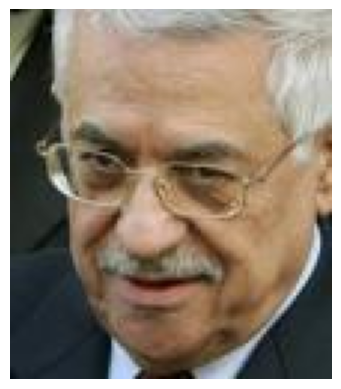

In [15]:
#Image data
FIW_images_path = "Videos FIW Dataset/train-faces"

person = FIW_images_path+"/F0001"+"/MID1"+"/P00001_face0.jpg"
image = Image.open("Videos FIW Dataset/train-faces/train-faces/F0001/MID1/P00001_face0.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()


In [77]:
#Load pre-trained FaceNet model for face detection and alignment
base_model = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN()

def GetEmbeddings(vidorim_path,frame = 0, video=False):
    # Open the video file
    cap = cv2.VideoCapture(vidorim_path)

    if video:
        #Extract frame
        frame_number = 10
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)# Set the video file's position to the desired frame number
        ret, frame = cap.read()# Read the frame from the video file
        cap.release()# Close the video file

        #Convert to PIL.
        if ret:#ret is False if no frame present
            # Convert the OpenCV frame (BGR) to a PIL image (RGB)
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            print("Failed to read frame.")

        #Align face image for better training
        aligned_image = mtcnn(image)
        #Create face embeddings using CNN model
        face_embedding = base_model(aligned_image.unsqueeze(0))
    else:
        
        image = Image.open(vidorim_path)
        
        #Align face image for better training
        aligned_image = mtcnn(image)
        
        
        #Create face embeddings using CNN model
        try:
            face_embedding = base_model(aligned_image.unsqueeze(0))
        except:
            return("None",False)
    
    
    return face_embedding,True

class video_manipulation:
    def __init__(self, mtcnn, base_model, directory):
        self.mtcnn = mtcnn
        self.base_model = base_model
        self.directory = directory  # Directory containing the videos
        self.frame_counts = {}  # Stores the count of frames for each video
        self.test_results = {}  # Stores test results
        self.current_video = None  # The video currently being processed
        self.current_frame = 0  # The frame currently being processed
        self.cap = None  # Video capture object

        self.count_frames(directory)

    def GetEmbeddings(self, vidorim_path, frame = 0, video=False):
        """
        Extracts face embeddings from the given image or video file.

        :param vidorim_path: Path to the video or image file.
        :param frame: For a video file, the specific frame to extract. Default is 0.
        :param video: Boolean flag indicating whether the file is a video. Default is False.
        :return: The face embedding and a boolean indicating success or failure.
        """
        
        # Open the video or image file
        cap = cv2.VideoCapture(vidorim_path)

        if video:  # If the file is a video
            # Set the video file's position to the desired frame number
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame) 
            ret, frame = cap.read()  # Read the frame from the video file
            cap.release()  # Close the video file

            if ret:  # ret is False if no frame is present
                # Convert the OpenCV frame (BGR) to a PIL image (RGB)
                image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            else:
                print("Failed to read frame.")
                return None, False

            # Align face in image for better training
            aligned_image = self.mtcnn(image)
            # Create face embeddings using the base model
            face_embedding = self.base_model(aligned_image.unsqueeze(0))
        else:  # If the file is an image
            # Open the image
            image = Image.open(vidorim_path)
            
            # Align face in image for better training
            aligned_image = self.mtcnn(image)
            
            # Create face embeddings using the base model
            try:
                face_embedding = self.base_model(aligned_image.unsqueeze(0))
            except:
                print("Failed to extract embeddings.")
                return None, False
        
        return face_embedding, True
    
    def count_frames(self, directory):
        """
        Counts the number of frames in each video in the given directory.

        :param directory: Path to the directory containing video files.
        """
        # Iterate over all files in the directory
        for filename in os.listdir(directory):
            if filename.endswith(".mp4") or filename.endswith(".avi"):  # assuming these are the video formats
                # Open the video file
                cap = cv2.VideoCapture(os.path.join(directory, filename))
                # Get and store the number of frames
                frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                self.frame_counts[filename] = frames
                cap.release()  # Close the video file
                
    def store_test_results(self, vidorim_path, test_results):
        """
        Stores the test results for a given video or image file.

        :param vidorim_path: Path to the video or image file.
        :param test_results: Test results to store.
        """
        # Store the test results
        self.test_results[vidorim_path] = test_results

    def mean_test_results(self, vidorim_path):
        """
        Calculates the mean of the test results for a given video or image
        """
        
        return np.mean(self.test_results[vidorim_path])
    
    def _next_video(self):
        if self.cap:
            self.cap.release()

        while self.frame_counts:
            self.current_video, total_frames = self.frame_counts.popitem()
            self.current_frame = 0  # Reset to the first frame
            self.cap = cv2.VideoCapture(os.path.join(self.directory, self.current_video))
            if self.cap.isOpened():
                return True

        return False

    def step(self, step_rate=1):
        while True:
            if not self.cap:
                if not self._next_video():
                    return None, False

            self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
            ret, frame = self.cap.read()

            if ret:
                image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                aligned_image = self.mtcnn(image)
                face_embedding = self.base_model(aligned_image.unsqueeze(0))
                self.current_frame += step_rate
                return face_embedding, True
            elif self._next_video():
                continue
            else:
                return None, False

# Models

## Conv Neur Network

In [9]:
class BalancedBinarySampler: #For random sampling with exactly 50 percent split
    def __init__(self, num_samples):
        half = num_samples // 2
        self.pool = [0]*half + [1]*(num_samples-half)
        random.shuffle(self.pool)

    def draw(self):
        if len(self.pool) == 0:
            raise ValueError("All numbers have been drawn")
        else:
            return self.pool.pop()

In [10]:
#Returns the first image in a file as only one image used
def get_image_files(directory):
    image_extensions = ['jpg', 'png', 'jpeg', 'gif', 'bmp']
    for filename in os.listdir(directory):
        if filename.split('.')[-1] in image_extensions:
            return filename

## Neural Network

In [30]:
# Define the architecture
model = Sequential()
model.add(Dense(128, input_dim=512, activation='relu')) # Input layer
model.add(Dense(64, activation='relu')) # Hidden layer
model.add(Dense(64, activation='relu')) # Hidden layer
model.add(Dense(1, activation='sigmoid')) # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#### Convolutional neural network

In [11]:

# CREATE AND COMPILE MODEL

model = Sequential()

embedding_height = 100
embedding_width = 100
embedding_channels = 512
input_shape = (embedding_height, embedding_width, embedding_channels)

num_classes = 2

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



#### 3d conv neural network

In [ ]:
from keras.layers import Dense, Conv3D, Flatten, MaxPooling3D

# Define the architecture
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(64,64,64,1))) # Input layer and first 3D convolutional layer
model.add(MaxPooling3D(pool_size=(2, 2, 2))) # 3D max pooling layer
model.add(Conv3D(64, (3, 3, 3), activation='relu')) # Second 3D convolutional layer
model.add(MaxPooling3D(pool_size=(2, 2, 2))) # 3D max pooling layer
model.add(Flatten()) # Flattening layer to convert 3D matrix to vector
model.add(Dense(64, activation='relu')) # Fully connected layer
model.add(Dense(1, activation='sigmoid')) # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train

In [31]:
# Preallocate empty arrays for embeddings and labels
X_train = []
y_train = []

face_path = "Videos FIW Dataset/train-faces/train-faces/"

line_limit = 3000
sampler = BalancedBinarySampler(line_limit)
num_skipped = 0

for cur_line in range(1,line_limit): #notebook.tqdm(range(1,line_limit)):
    
    
    if sampler.draw() == 1:# Sample relatives
    
        p1 = FIW_train_csv["p1"][cur_line]
        p2 = FIW_train_csv["p2"][cur_line]
        fam_label = 1
        #fam_label = FIW_train_csv["ptype"][cur_line]
        
        img1 = get_image_files(face_path+p1)
        img2 = get_image_files(face_path+p2)
        
        path_1 = face_path+p1+"/"+img1
        path_2 = face_path+p2+"/"+img2
    
    else:# Sample strangers
        p1 = FIW_train_csv["p1"][cur_line]
        
        p2 = FIW_train_csv["p2"][cur_line+20]
        fam_label = 0
        #fam_label = FIW_train_csv["ptype"][cur_line]
        
        img1 = get_image_files(face_path+p1)
        img2 = get_image_files(face_path+p2)
        
        path_1 = face_path+p1+"/"+img1
        path_2 = face_path+p2+"/"+img2
        
    embeddings_p1,bool1 = GetEmbeddings(path_1)
    embeddings_p2,bool2 = GetEmbeddings(path_2)
    
    if bool1 or bool2:
        pass
    else:
        num_skipped += 1
        continue
        
    if embeddings_p1 == "None" or embeddings_p2 == "None":
        num_skipped += 1
        continue
    
    emb_diff = embeddings_p1-embeddings_p2
    emb_diff_np = emb_diff.detach().numpy().reshape(-1)    
    
    X_train.append(emb_diff_np)
    y_train.append(fam_label) #1 if related 0 if not
    
    # Convert X_train and y_train to numpy arrays
    #X_train_np = np.array([x.detach().numpy() for x in X_train])
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train) #1 if related 0 if not
    
    #Fit model
    model.fit(X_train_np, y_train_np, epochs=1, batch_size=1)
    


2961/2961 [==============================] - 10s 4ms/step - loss: 0.0654 - accuracy: 0.9595


#### Multiple epochs and variable batch size

In [93]:
face_path = "Videos FIW Dataset/train-faces/train-faces/"

line_limit = 3000
sampler = BalancedBinarySampler(line_limit)
num_skipped = 0

losses = []
accuracies = []

batch_size = 100
num_epochs = 2

for epoch in range(num_epochs):  # Iterate over each epoch
    for i in range(0, line_limit, batch_size):  # Iterate over each batch in your data
        X_train = []
        y_train = []
        for j in range(i, min(i+batch_size, line_limit)):  # Iterate over each line in the current batch

            if sampler.draw() == 1:# Sample relatives
                p1 = FIW_train_csv["p1"][j]
                p2 = FIW_train_csv["p2"][j]
                fam_label = 1
                img1 = get_image_files(face_path+p1)
                img2 = get_image_files(face_path+p2)
                path_1 = face_path+p1+"/"+img1
                path_2 = face_path+p2+"/"+img2

            else: # Sample strangers
                p1 = FIW_train_csv["p1"][j]
                p2 = FIW_train_csv["p2"][j+20]
                fam_label = 0
                img1 = get_image_files(face_path+p1)
                img2 = get_image_files(face_path+p2)
                path_1 = face_path+p1+"/"+img1
                path_2 = face_path+p2+"/"+img2

            embeddings_p1,bool1 = GetEmbeddings(path_1)
            embeddings_p2,bool2 = GetEmbeddings(path_2)

            if bool1 or bool2:
                pass
            else:
                num_skipped += 1
                continue

            if embeddings_p1 == "None" or embeddings_p2 == "None":
                num_skipped += 1
                continue

            emb_diff = embeddings_p1-embeddings_p2
            emb_diff_np = emb_diff.detach().numpy().reshape(-1)

            X_train.append(emb_diff_np)
            y_train.append(fam_label)

        X_train_np = np.array(X_train)
        y_train_np = np.array(y_train)

        model.fit(X_train_np, y_train_np, epochs=1, batch_size=batch_size)
history = model.fit()

1/1 [==============================] - 0s 60ms/step - loss: 3.1784 - accuracy: 0.6400


#### Quantity of values skipped

In [ ]:
print("Number of skipped lines: ",num_skipped)
print("Number of lines: ",line_limit)
print("Ratio skipped: ",num_skipped/line_limit)

Number of skipped lines:  38
Number of lines:  3000
Ratio skipped:  0.012666666666666666


#### Plot loss graph

In [91]:
plt.plot(model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

TypeError: 'History' object is not subscriptable

In [ ]:
# Loss on validation
history = model.fit(X_train_np, y_train_np, validation_data=(X_valid_np, y_valid_np), epochs=num_epochs, batch_size=batch_size, verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Test

### Test with image test data

In [35]:
## TEST IMAGE

test_line_limit = line_limit+1

sampler_test = BalancedBinarySampler(line_limit)
X_test = []
y_test = []

num_skipped_test = 0

for cur_line in notebook.tqdm(range(test_line_limit,6000)):
    
    
    if sampler_test.draw() == 1:# Sample relatives
    
        p1 = FIW_train_csv["p1"][cur_line]
        p2 = FIW_train_csv["p2"][cur_line]
        fam_label = 1
        #fam_label = FIW_train_csv["ptype"][cur_line]
        
        img1 = get_image_files(face_path+p1)
        img2 = get_image_files(face_path+p2)
        
        path_1 = face_path+p1+"/"+img1
        path_2 = face_path+p2+"/"+img2
    
    else:# Sample strangers
        p1 = FIW_train_csv["p1"][cur_line]
        
        p2 = FIW_train_csv["p2"][cur_line+20]
        fam_label = 0
        #fam_label = FIW_train_csv["ptype"][cur_line]
        
        img1 = get_image_files(face_path+p1)
        img2 = get_image_files(face_path+p2)

        path_1 = face_path+p1+"/"+img1
        path_2 = face_path+p2+"/"+img2
        
    embeddings_p1,bool1 = GetEmbeddings(path_1)
    embeddings_p2,bool2 = GetEmbeddings(path_2)
    
    if bool1 == False or bool2 == False:
        num_skipped_test += 1
        continue
        
    elif embeddings_p1 == "None" or embeddings_p2 == "None":
        num_skipped_test += 1
        continue

    emb_diff = embeddings_p1-embeddings_p2
    emb_diff_np = emb_diff.detach().numpy().reshape(-1)    
    
    X_test.append(emb_diff_np)
    y_test.append(fam_label) #1 if related 0 if not
    
# Convert X_test and y_test to numpy arrays
X_test_np = np.array(X_test)
y_test_np = np.array(y_test) #1 if related 0 if not

  0%|          | 0/2999 [00:00<?, ?it/s]

In [36]:
print("Number of skipped lines: ",num_skipped_test)
print("Number of lines: ",6000-line_limit)
print("Ratio skipped: ",num_skipped_test/6000-line_limit)

Number of skipped lines:  45
Number of lines:  3000
Ratio skipped:  -2999.9925


#### Results

In [37]:
#Test Test
predictions = model.predict(X_test_np)
class_predictions = (predictions > 0.5).astype(int)

num_corr = 0
for i in range(len(y_test_np)):
    if y_train[i] == class_predictions[i][0]:
        num_corr += 1

acc = num_corr/len(y_test_np)
print(acc)

0.496614759647935


In [38]:
#Train test
predictions = model.predict(X_train_np)
class_predictions = (predictions > 0.5).astype(int)

num_corr = 0
for i in range(len(y_train)):
    if y_train[i] == class_predictions[i]:
        num_corr += 1

acc = num_corr/len(y_train)
print(acc)

0.9601485984464708


### Test with video data


relations_dict_final - Dictionary containing all relationships (Including pairs)

all_data - A dictionary with each family member and the names of their videos

G - graph over all familial relations

In [80]:
#Video test
## TEST IMAGE

X_test = []
y_test = []

family_edges = list(G.edges)

extractor = video_manipulation(mtcnn, base_model,"Videos Clipped/40/1")
embedding, status = extractor.GetEmbeddings("Videos Clipped/40/1/40-1-2022-1-1.mp4.mp4",frame = 0, video=True)

extractor.count_frames("Videos Clipped/40/1")

In [81]:
family_edges[0]

('40/1', '40/4')

In [83]:
step_rate_both = 100
probabilities = {}
X_test_vid = []
y_test_vid = []
for fam_bond in family_edges:
    video1 = video_manipulation(mtcnn, base_model,"Videos Clipped/"+fam_bond[0])
    video2 = video_manipulation(mtcnn, base_model,"Videos Clipped/"+fam_bond[1])


    while True:
        embedding1,status1 = video1.step(step_rate=step_rate_both)
        embedding2,status2 = video2.step(step_rate=step_rate_both)
        if not status1 or not status2:
            break
        sub_embedding = embedding1-embedding2
        sub_embedding_np = sub_embedding.detach().numpy().reshape(-1)   
        X_test_vid.append(emb_diff_np)
        y_test_vid.append(fam_label)
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test)
    probabilities[fam_bond] = [X_test_np,y_test_np]

AttributeError: 'NoneType' object has no attribute 'unsqueeze'

In [ ]:
#Test Test video
for fam_bond_2 in family_edges:
    X_vals,y_vals = probabilities[fam_bond_2]
    predictions = model.predict(X_vals)


predictions = model.predict(X_test_np)
class_predictions = (predictions > 0.5).astype(int)

num_corr = 0
for i in range(len(y_test_np)):
    if y_train[i] == class_predictions[i][0]:
        num_corr += 1

acc = num_corr/len(y_test_np)
print(acc)